In [1]:
# couple issues that I've seen. Single images are not enough to allow a classification
# we might need 24 images per day to get a daily average
# other problems might be the time of day? perhaps dark images are not useful?

In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
import src.tools as tools
# Dependency imports
import tensorflow_probability as tfp
import tensorflow_addons as tfa

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
stations = ['ParkersBrook','BrownsBrook','GrantPoole']
station_name = stations[2]

wd = f'/datadrive/stream_data/training/{station_name}'
bins = ['train', 'val', 'test']
data ={}
for b in bins:
    datatable_name = f'{wd}/{b}_table.csv'
    data[b] = pd.read_csv(datatable_name)

In [3]:
#lets get the y data
train_dataset = tools.create_regression_data_from_dataframe(data['train'])
val_dataset = tools.create_regression_data_from_dataframe(data['val'])
#test_dataset = tools.create_regression_data_from_dataframe(data['test'])

In [4]:
#input_shape = Xtrain[0].shape
input_shape = (480, 640, 3)

In [13]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

tfd = tfp.distributions
tfb = tfp.bijectors

def build_cnn(input_shape):
    
    ##model building
    model_in = tf.keras.layers.Input(shape=input_shape)

    conv_1 = tf.keras.layers.Conv2D(16, 3,\
                     activation='relu', padding='same',\
                     input_shape=input_shape)(model_in)
    max_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
    conv_2 = tf.keras.layers.Conv2D(32, 3,\
                     activation='relu', padding='same',\
                     input_shape=input_shape)(max_1)
    max_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
    conv_3 = tf.keras.layers.Conv2D(64, 3,\
                     activation='relu', padding='same',\
                     input_shape=input_shape)(max_2)
    max_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_3)
    flat_1 = tf.keras.layers.Flatten()(max_3)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(flat_1)
    model_out = tf.keras.layers.Dense(1)(dense_1)
    model = tf.keras.Model(model_in, model_out)
    return model

def NLL(y, distr): 
    return -distr.log_prob(y) 

def normal_sp(params, bias_size=0, hyperparam=0.001): 
    n = params + bias_size
    c = np.log(np.expm1(1.))
    return tfd.Normal(loc=params[...,:1],\
                      scale=1e-5 + tf.math.softplus(hyperparam * params[...,1:]))


# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    out = tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])
    return out

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    out = tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])
    return out

def build_bayes_cnn(input_shape):
    
    ##model building
    model_in = tf.keras.layers.Input(shape=input_shape)
    #32 convolution filters used each of size 3x3
    conv_1 = tfp.python.layers.Convolution2DFlipout(16, kernel_size=(3, 3),\
                                                    padding="same", \
                                                    activation='relu',\
                                                   input_shape=input_shape)(model_in)
    #convolutional layer with rectified linear unit activation
    max_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
    #randomly turn neurons on and off to improve convergence
    conv_2 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3),\
                                                    padding="same",\
                                                    activation='relu')(max_1)
    max_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
    conv_3 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3),\
                                                    padding="same",\
                                                    activation='relu')(max_2)
    max_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_3)
    #flatten since too many dimensions, we only want a classification output
    flat_1 = tf.keras.layers.Flatten()(max_3)
    #fully connected to get all relevant data
    #dense_1 = tfp.python.layers.DenseFlipout(128, activation='relu')(flat_1)
    #hidden = Dense(20, activation='relu')(dense_1)
    #params = Dense(2, activation='relu')(hidden)
    #dense_2 = tfp.python.layers.DenseFlipout(1, activation=None)(dense_1)
    #dense_2 = Dense(2, activation='relu')(dense_1)
    dense_2 = tfp.layers.DenseVariational(1+1, posterior_mean_field, \
                               prior_trainable,\
                               kl_weight=1/X_train.shape[0])(flat_1)
    model_out = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[...,:1],\
                                                                   scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])))(dense_2)
    
    #model_out = tfp.layers.DistributionLambda(normal_sp)(dense_2)
    model = tf.keras.Model(model_in, model_out)
    return model

def my_dist(params):
    return tfd.Normal(loc=params, scale=0.0003)

def build_simple_bcnn(input_shape):
    model_in = tf.keras.layers.Input(shape=input_shape)
    conv_1 = tfp.python.layers.Convolution2DFlipout(16, kernel_size=(3, 3),\
                                                    padding="same", \
                                                    activation='relu',\
                                                   input_shape=input_shape)(model_in)
    max_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
    conv_2 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3),\
                                                padding="same", \
                                                activation='relu',\
                                               input_shape=input_shape)(max_1)
    max_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
    conv_3 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3),\
                                                padding="same", \
                                                activation='relu',\
                                               input_shape=input_shape)(max_2)
    max_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_3)
    flat_1 = tf.keras.layers.Flatten()(max_3)
    dense_1 = Dense(128, activation='relu')(flat_1)
    params = Dense(1)(dense_1)
    dist = tfp.layers.DistributionLambda(my_dist)(params)
    model = Model(inputs=model_in, outputs=dist)
    return model
    

In [148]:
epochs = 100
input_shape = (480, 640, 3)
cnn = build_simple_bcnn(input_shape)
#optimizer = tf.keras.optimizers.Adam(lr=0.01)
optimizer = tfa.optimizers.AdamW(lr=0.0075, weigh_decay=0.001)
cnn.compile(loss=NLL,\
            metrics=tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,)),\
            optimizer=optimizer)
batch_size = 18
history = cnn.fit(train_dataset.shuffle(20).padded_batch(batch_size),\
                    validation_data=val_dataset.batch(batch_size),\
                    epochs=epochs)

Epoch 1/100
32/32 [==============================] - 14s 445ms/step - loss: 471022.2812 - r_square: 0.5958 - val_loss: 801535.0000 - val_r_square: 0.3491
Epoch 2/100
32/32 [==============================] - 14s 442ms/step - loss: 467032.0625 - r_square: 0.5996 - val_loss: 711600.2500 - val_r_square: 0.4277
Epoch 3/100
32/32 [==============================] - 14s 444ms/step - loss: 433916.8125 - r_square: 0.6320 - val_loss: 917979.1250 - val_r_square: 0.2469
Epoch 4/100
32/32 [==============================] - 14s 446ms/step - loss: 505298.8438 - r_square: 0.5621 - val_loss: 739245.0000 - val_r_square: 0.4034
Epoch 5/100
32/32 [==============================] - 14s 445ms/step - loss: 509477.7188 - r_square: 0.5581 - val_loss: 794259.8125 - val_r_square: 0.3555
Epoch 6/100
32/32 [==============================] - 14s 445ms/step - loss: 456195.6250 - r_square: 0.6103 - val_loss: 710673.0000 - val_r_square: 0.4286
Epoch 7/100
32/32 [==============================] - 14s 446ms/step - loss: 

Epoch 54/100
32/32 [==============================] - 14s 450ms/step - loss: 224259.0781 - r_square: 0.8371 - val_loss: 511157.5625 - val_r_square: 0.6030
Epoch 55/100
32/32 [==============================] - 14s 450ms/step - loss: 226095.4375 - r_square: 0.8353 - val_loss: 497357.5312 - val_r_square: 0.6151
Epoch 56/100
32/32 [==============================] - 14s 450ms/step - loss: 226609.7812 - r_square: 0.8348 - val_loss: 539247.1875 - val_r_square: 0.5785
Epoch 57/100
32/32 [==============================] - 14s 448ms/step - loss: 214960.5938 - r_square: 0.8462 - val_loss: 464441.1250 - val_r_square: 0.6439
Epoch 58/100
32/32 [==============================] - 14s 450ms/step - loss: 247680.0625 - r_square: 0.8141 - val_loss: 508072.0000 - val_r_square: 0.6058
Epoch 59/100
32/32 [==============================] - 14s 447ms/step - loss: 791874.3125 - r_square: 0.2812 - val_loss: 998114.0000 - val_r_square: 0.1767
Epoch 60/100
32/32 [==============================] - 14s 447ms/step -

In [143]:
modelname = 'simple_bcnn_regression'
import os
if not os.path.exists(f'/datadrive/model/{station_name}/{modelname}'):
    subdirs = ['history','weights']
    for sub in subdirs:
        os.makedirs(f'/datadrive/model/{station_name}/{modelname}/{sub}')
pd.DataFrame(history.history).to_csv(f'/datadrive/model/{station_name}/{modelname}/history/{modelname}.csv')
cnn.save(f'/datadrive/model/{station_name}/{modelname}/weights/{modelname}.h5') 
jsonfile = f'/datadrive/model/{station_name}/{modelname}/weights/{modelname}.json'
model_json = cnn.to_json()
with open(jsonfile, "w") as json_file:
    json_file.write(model_json)

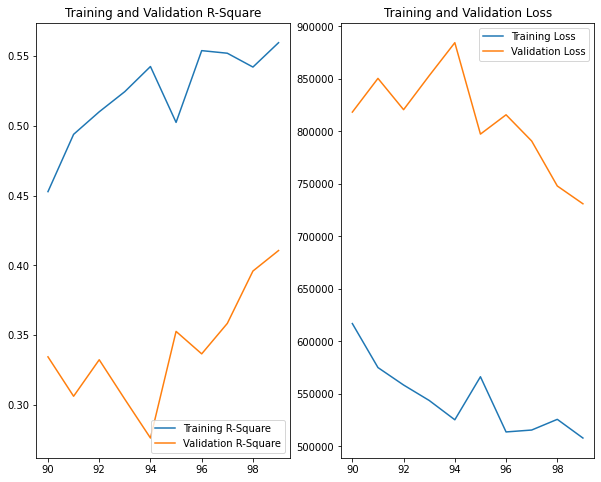

In [144]:
skip= 90 
acc = history.history['r_square'][skip:]
val_acc = history.history['val_r_square'][skip:]

loss = history.history['loss'][skip:]
val_loss = history.history['val_loss'][skip:]

epochs_range = range(epochs)[skip:]

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training R-Square')
plt.plot(epochs_range, val_acc, label='Validation R-Square')
plt.legend(loc='lower right')
plt.title('Training and Validation R-Square')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
test_dataset = tools.create_regression_data_from_dataframe(data['test'])

In [145]:
n = 20
yhat = np.array([cnn.predict(test_dataset.batch(batch_size)) for _ in range(n)])

In [146]:
import tensorflow_datasets as tfds
tst = np.array([i for i in tfds.as_numpy(test_dataset)])
test_im = tst[:,0]
y = tst[:,1]

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level 

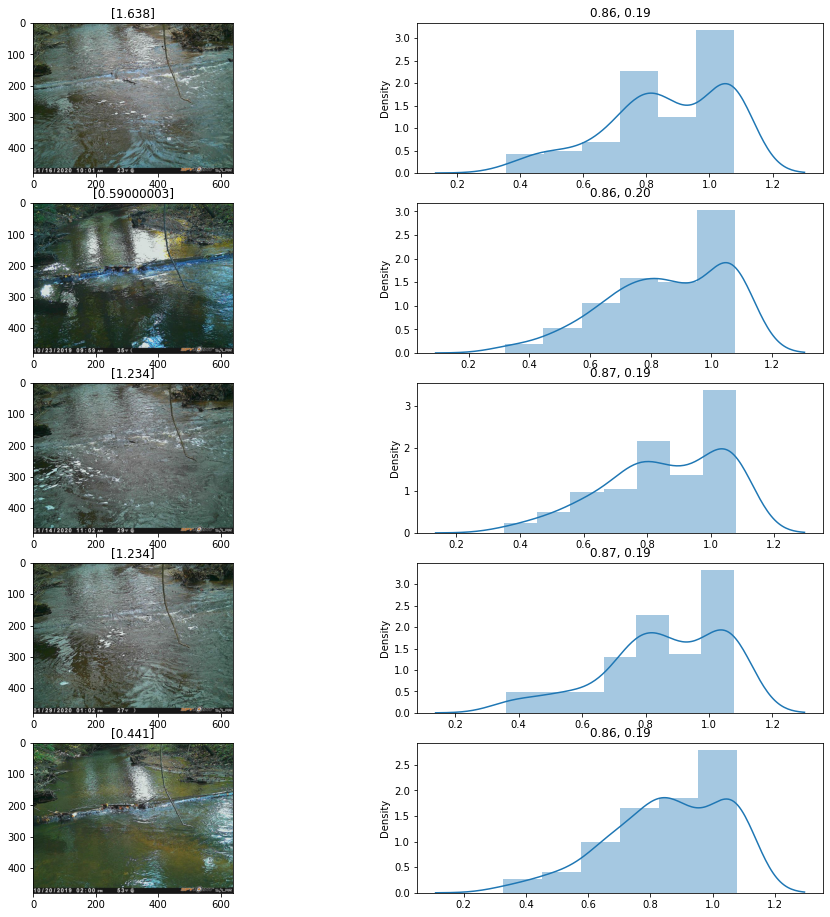

In [147]:
f, ax = plt.subplots(5,2, figsize=(16,16))
for i in range(5):
    ax[i,0].imshow(test_im[i])
    ax[i,0].set_title(np.exp(y[i]))

    sns.distplot(np.exp(yhat[i,:,0]), ax=ax[i,1])
    #ax[i,1].hist(np.exp(yhat[i,:,0]))
    ax[i,1].set_title(f'{np.median(np.exp(yhat[i,:,0])):0.2f}, {np.std(np.exp(yhat[i,:,0])):0.2f}')